# Testing and developing Maehara's method

I'll now try to make a quick test of the method in Maehara & al. First load up the modules and the data, and take a look at the lightcurve:

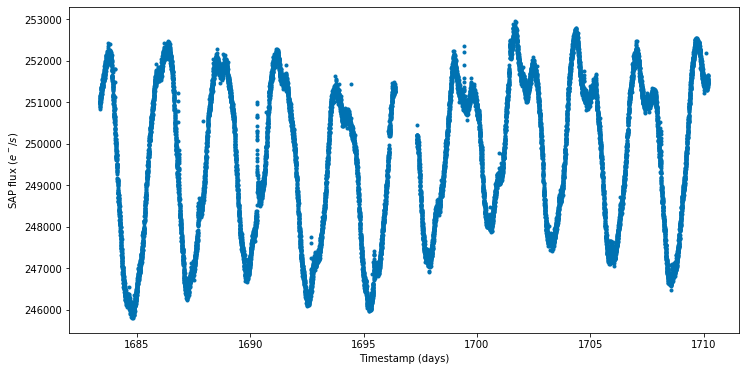

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy
mp.style.use('seaborn-colorblind')

def lcplot(t,f,color=""):
    mp.rcParams['figure.figsize'] = [12, 6]
    plt.plot(t,f,color+".")
    plt.xlabel("Timestamp (days)")
    plt.ylabel(r"SAP flux ($e^-/s$)")

hdul = fits.open('tess2019198215352-s0014-0000000159613900-0150-s_lc.fits')
lcdata = hdul[1].data
pdcflux_raw = lcdata.field(7)
time_raw = lcdata.field(0)
has_errors = np.isnan(pdcflux_raw)
pdcflux = pdcflux_raw[~has_errors]
time = time_raw[~has_errors]

lcplot(time,pdcflux)

Then, analyze the distribution in the differences between consecutive data points. We see right away that the pauses in the data will result in a larger difference, so we will also divide by the time between the data points to compensate for it.

In [2]:
N = len(pdcflux)
jumps = np.zeros(N-1)
for i in range(1,N):
    jumps[i-1] = (pdcflux[i]-pdcflux[i-1])/(time[i]-time[i-1])

Take a quick look at the statistics using a histogram:

Text(0.5, 1.0, 'Absolute value (log)')

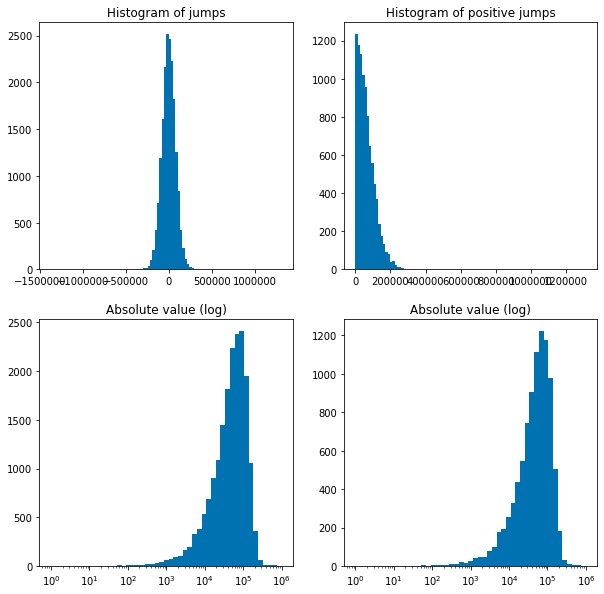

In [3]:
mp.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(2,2)
ax[0,0].hist(jumps,bins=100)
ax[0,0].set_title("Histogram of jumps")
ax[1,0].hist(np.abs(jumps),bins=np.logspace(np.log10(1.0),np.log10(10.**6), 50))
ax[1,0].set_xscale('log')
ax[1,0].set_title("Absolute value (log)")
ax[0,1].hist(jumps[jumps > 0],bins=100)
ax[0,1].set_title("Histogram of positive jumps")
ax[1,1].hist(np.abs(jumps[jumps > 0]),bins=np.logspace(np.log10(1.0),np.log10(10.**6), 50))
ax[1,1].set_xscale('log')
ax[1,1].set_title("Absolute value (log)")

I expected a power-law distribution of some sort, but this should do. Then let's look at the percentiles.

In [4]:
top1 = np.percentile(jumps[jumps > 0], 99.0, axis=None, out=None)
print(top1)

220157.80658646254


Not all that much, considering how bright the star is. Let's see how many flares get flagged that way:

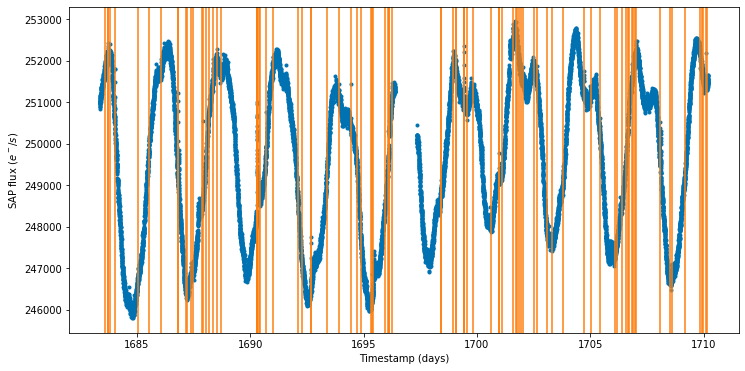

In [5]:
lcplot(time,pdcflux)

for i in range(N-1):
    if jumps[i] > top1:
        plt.axvline(time[i],color='tab:orange')

Clearly not all of these can be superflares. Let's try a higher threshold, say 0.1 percent:

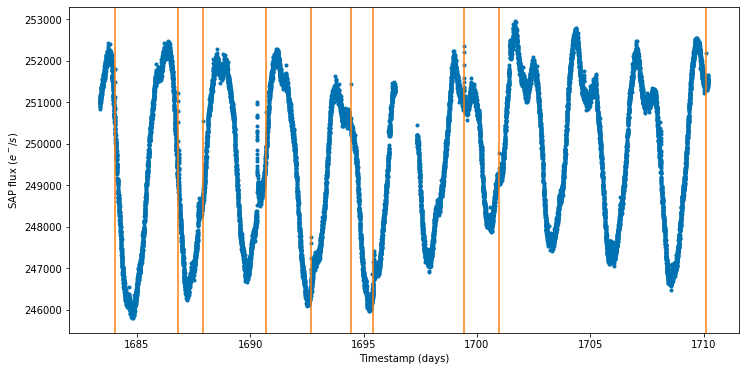

In [6]:
top01 = np.percentile(jumps[jumps > 0], 99.9, axis=None, out=None)
lcplot(time,pdcflux)

for i in range(N-1):
    if jumps[i] > top01:
        plt.axvline(time[i],color='tab:orange')

Now we are getting somewhere, but some non-obvious "flares" get tagged, and the method misses out the obvious flare near 1690. 0.2?

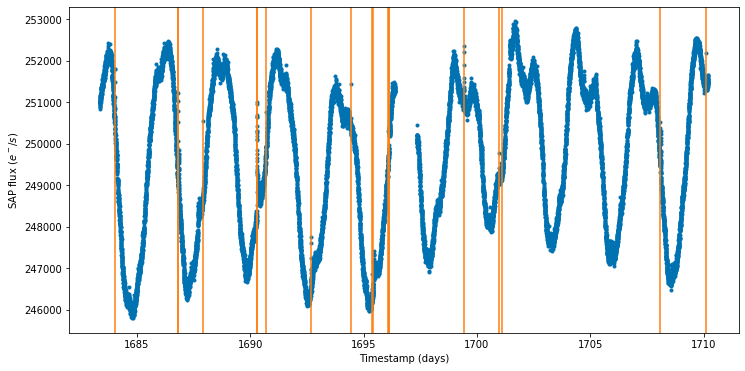

In [7]:
top02 = np.percentile(jumps[jumps > 0], 99.8, axis=None, out=None)
lcplot(time,pdcflux)

for i in range(N-1):
    if jumps[i] > top02:
        plt.axvline(time[i],color='tab:orange')

Now we get a little more detail. Let's use this threshold for now.

Then we need to somehow remove the background "long-term signal". This is challenging, since the star appears to have at least two periods from differential rotation or other causes. One simple option is to look at the neighborhood of the flare in a greater timescale (maybe proportional to the flare length, somehow?) and fit a curve to that part. Let's look at one flare in detail to see how this might work (the one around 1686-1687).

216


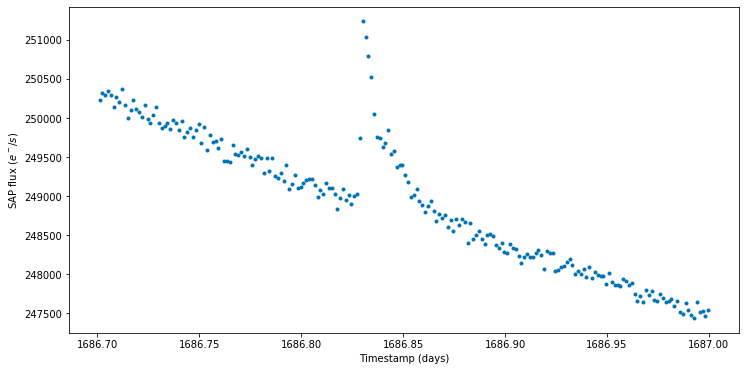

In [8]:
def slice_t_pdc(t,lc,t0,t1):
    '''
    Returns a tuple (tslice, lcslice) of the time and the lightcurve arrays
    between t0 and t1
    '''
    tslice1 = t[t < t1]
    tslice2 = tslice1[tslice1 > t0]
    lslice1 = lc[t < t1]
    lslice2 = lslice1[tslice1 > t0]
    return (tslice2,lslice2)

tslice,fslice = slice_t_pdc(time,pdcflux,1686.7,1687)
lcplot(tslice,fslice)
print(len(tslice))

We see the flare roughly at 1686.85. Now we want to fit some sort of a curve that would let us ignore the flare. Since we have a short window of time, we can use a simple linear fit.

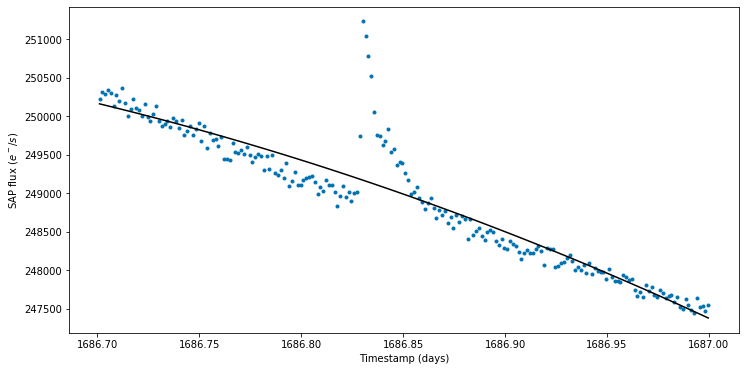

In [9]:
x = np.linspace(np.min(tslice),np.max(tslice))
coeffs = np.polyfit(tslice,fslice,2)
f = np.poly1d(coeffs)
y = f(x)
lcplot(tslice,fslice)
plt.plot(x,y,"k")

(March 4)

Subtract the linear trend from the signal, and we get:

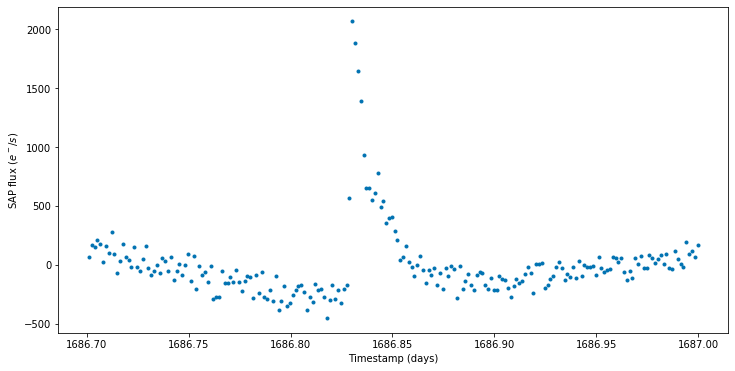

In [10]:
lcplot(tslice,fslice-f(tslice))

Polynomial fit appears to give an "okay" approximation, but it does not seem to be able to follow the background curvature properly. Right here it seems acceptable, but it could be a big issue later. Let's try a different flare with a bigger underlying curvature:

Fitting might work here, after all. But we will want to make the fit robust so that the flare itself won't impact it too much.

The most elementary robust fitting method is to exclude the outliers, say 10% of the data points furthest from the line. Let's do that.

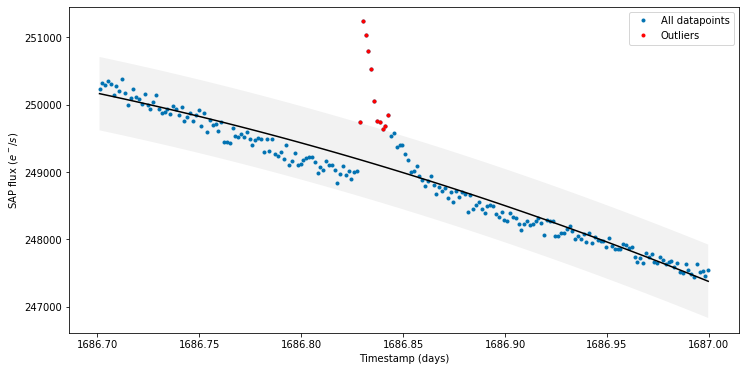

In [11]:
deviations = np.abs(fslice-f(tslice))
maxdist = np.percentile(deviations, 95.0)
outliers = fslice[deviations > maxdist]
outliers_t = tslice[deviations > maxdist]

lcplot(tslice,fslice)
lcplot(outliers_t,outliers,color="r")
plt.legend(["All datapoints","Outliers"])
plt.plot(x,y,"k")
plt.fill_between(x, y-maxdist, y+maxdist,
                facecolor='gray', alpha=0.1)

Now redo the fit without the outliers:

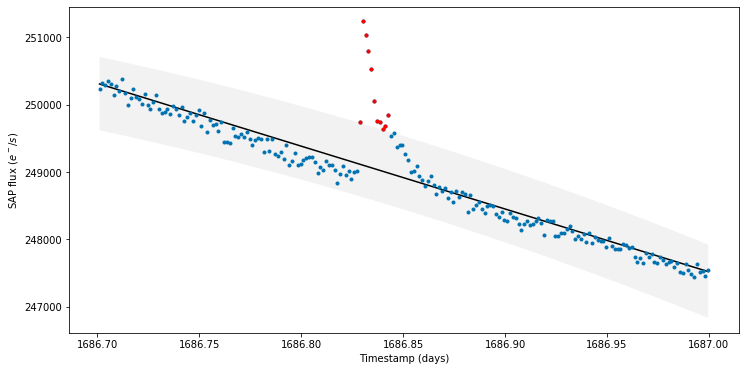

In [12]:
f_no_outliers = fslice[deviations < maxdist]
t_no_outliers = tslice[deviations < maxdist]
coeffs = np.polyfit(tslice,fslice,1)
f2 = np.poly1d(coeffs)
y2 = f2(x)
plt.plot(x,y2,"k")
plt.fill_between(x, y-maxdist, y+maxdist,
                facecolor='gray', alpha=0.1)
lcplot(tslice,fslice)
lcplot(outliers_t,outliers,color="r")

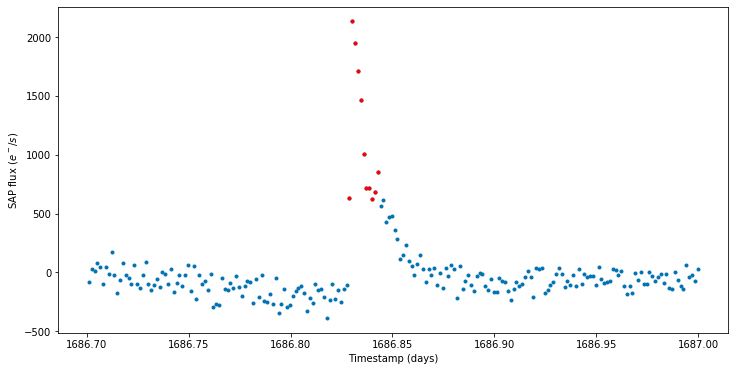

In [13]:
lcplot(tslice,fslice-f2(tslice))
lcplot(outliers_t,outliers-f2(outliers_t),color="r")

Again, we get a little bit of curvature that gets ignored. Iterate a second time:


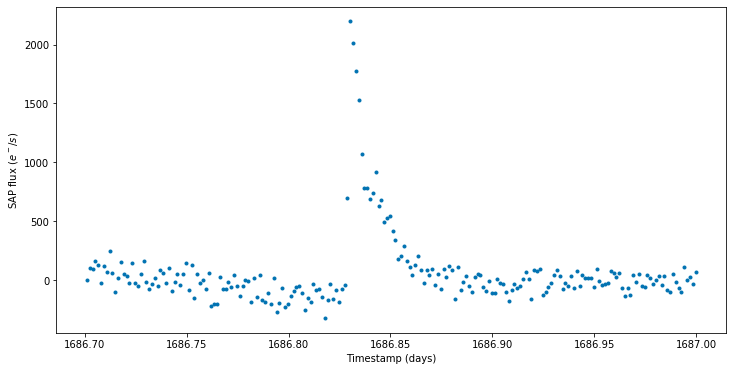

In [14]:
tslice_original = tslice
fslice_original = fslice
tslice = t_no_outliers
fslice = f_no_outliers


deviations = np.abs(fslice-f(tslice))
maxdist = np.percentile(deviations, 95.0)
outliers = fslice[deviations > maxdist]
outliers_t = tslice[deviations > maxdist]

f_no_outliers = fslice[deviations < maxdist]
t_no_outliers = tslice[deviations < maxdist]
coeffs = np.polyfit(tslice,fslice,1)
f2 = np.poly1d(coeffs)
y2 = f2(x)
lcplot(tslice_original,fslice_original-f2(tslice_original))

Clearly diminishing returns. But maybe necessary in some cases. In any case, the flare is now clearly distinct from the background signal; we can start to analyze it now.

What I learned:

- jumps work as an initial guess

- polynomial fit has some issues when used raw

- robust fitting helps

In the next notebook, I will:

- identify flares across the whole time series

- use the same approach for all of them -> generate many mini-plots, see which ones need to be cancelled

- try to find other properties like peaks, duration, etc